In [18]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import UnidentifiedImageError
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc

In [19]:
# Directory containing images
image_folder = 'photos/'

# Directory containing image metadata
photos_df = pd.read_json('photos.json', lines=True)

photos_df.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


In [21]:
photos_df['label'].unique()

photos_df.info()
photos_df['label'].isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200100 entries, 0 to 200099
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   photo_id     200100 non-null  object
 1   business_id  200100 non-null  object
 2   caption      200100 non-null  object
 3   label        200100 non-null  object
dtypes: object(4)
memory usage: 6.1+ MB


0

In [22]:
# Count the number of occurrences of each label
label_counts = photos_df['label'].value_counts()
sorted_label_counts = label_counts.sort_values(ascending=False)

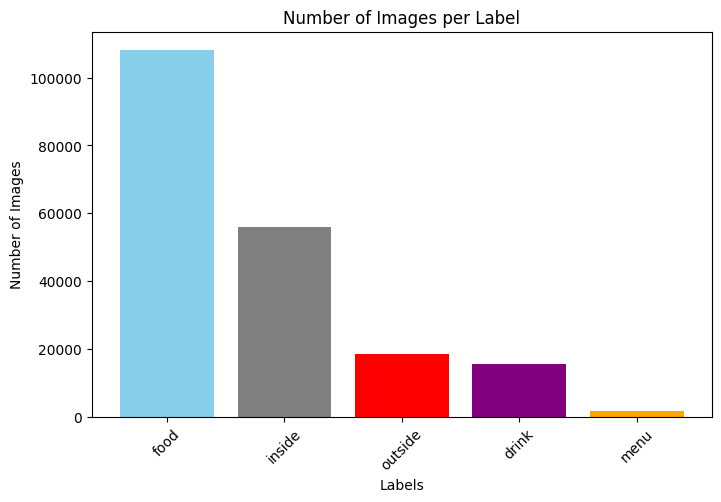

In [23]:
# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(sorted_label_counts.index, sorted_label_counts.values, color=['skyblue', 'grey', 'red', 'purple', 'orange'])
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images per Label')
plt.xticks(rotation=45)
plt.show()

In [24]:
def load_images_with_metadata(photo_df, image_folder, max_images_per_label=1678):
    images, labels = [], []
    label_counts = {}

    for index, row in photo_df.iterrows():
        photo_id = row['photo_id']
        label = row['label']

        if label not in label_counts:
            label_counts[label] = 0
        if label_counts[label] >= max_images_per_label:
            continue

        img_path = os.path.join(image_folder, f"{photo_id}.jpg")

        try:
            img = load_img(img_path, target_size=(128, 128))
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img_array)
            labels.append(label)
            label_counts[label] += 1

        except FileNotFoundError:
            print(f"Image {img_path} not found.")
        except UnidentifiedImageError:
            print(f"Skipping {img_path}, not a valid image file.")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

    X = np.array(images)
    y = np.array(labels)

    return X, y

X, y = load_images_with_metadata(photos_df, image_folder)

Skipping photos/ydm3g1wUWSxJnMPgHk2JhQ.jpg, not a valid image file.


In [25]:
print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]} and {len(y)} labels.")

Loaded 8390 images with shape (128, 128, 3) and 8390 labels.


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
# One-Hot Encoding
onehot_encoder = OneHotEncoder(sparse=False)

# Fit and transform the training labels
y_train = onehot_encoder.fit_transform(y_train.reshape(-1, 1))  # Reshape if needed

# Transform the testing labels
y_test = onehot_encoder.transform(y_test.reshape(-1, 1))

# Check the shape of the encoded labels
print(f"Encoded y_train shape: {y_train.shape}")
print(f"Encoded y_test shape: {y_test.shape}")

Encoded y_train shape: (6712, 5)
Encoded y_test shape: (1678, 5)


C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [28]:
num_images = 16
plt.figure(figsize=(16, 12))

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

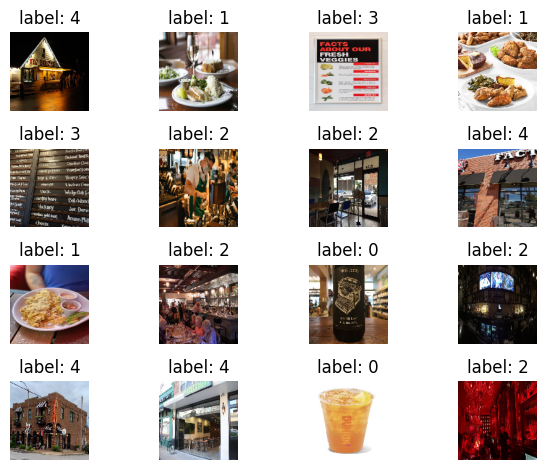

In [29]:
for i in range(num_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i])
    plt.title(f'label: {np.argmax(y_train[i])}')  # Show the class label index
    plt.axis('off')

plt.tight_layout()
plt.show()

# DNN Model

In [30]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2.5, restore_best_weights=True)

In [31]:
def create_model(dropout_rate=0.2, optimizer='adam'):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(128, 128, 3)),  
        tf.keras.layers.Flatten(),                      
        tf.keras.layers.Dense(256, activation='relu'),  
        tf.keras.layers.Dropout(0.2),                   
        tf.keras.layers.Dense(128, activation='relu'),  
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),    
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),    
        tf.keras.layers.Dense(len(onehot_encoder.categories_[0]), activation='softmax')  # Adjust output layer size
    ])
    return model

In [33]:
best_params = {
    'batch_size': 32,
    'dropout_rate': 0.2,
    'epochs': 25,
    'optimizer': 'adam'
}

In [34]:
# Create the model
model = create_model(dropout_rate=best_params['dropout_rate'])

# Set learning rate and optimizer
learning_rate = 0.00001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# View the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,626,565 (48.17 MB)

 Trainable params: 12,626,565 (48.17 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Train the DNN model
history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=best_params['epochs'],           
    batch_size=best_params['batch_size'],  
    callbacks=[early_stopping],
    verbose=1  
)

Epoch 1/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 55s 246ms/step - accuracy: 0.2261 - loss: 1.6145 - val_accuracy: 0.3117 - val_loss: 1.5154
Epoch 2/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 51s 242ms/step - accuracy: 0.3018 - loss: 1.5342 - val_accuracy: 0.3826 - val_loss: 1.4682
Epoch 3/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 46s 219ms/step - accuracy: 0.3169 - loss: 1.5048 - val_accuracy: 0.3957 - val_loss: 1.4268
Epoch 4/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 45s 214ms/step - accuracy: 0.3526 - loss: 1.4765 - val_accuracy: 0.4035 - val_loss: 1.4119
Epoch 5/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 44s 209ms/step - accuracy: 0.3704 - loss: 1.4477 - val_accuracy: 0.4267 - val_loss: 1.3890
Epoch 6/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 45s 214ms/step - accuracy: 0.3741 - loss: 1.4261 - val_accuracy: 0.4154 - val_loss: 1.3938
Epoch 7/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 81s 209ms/step - accuracy: 0.3903 - loss: 1.4218 - val_accuracy: 0.4303 - val_loss: 1.3546
Epoch 8/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 43s 205ms/step - accuracy: 0.3906 - loss: 1

In [36]:
# Make predictions on training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Convert predictions to class labels
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


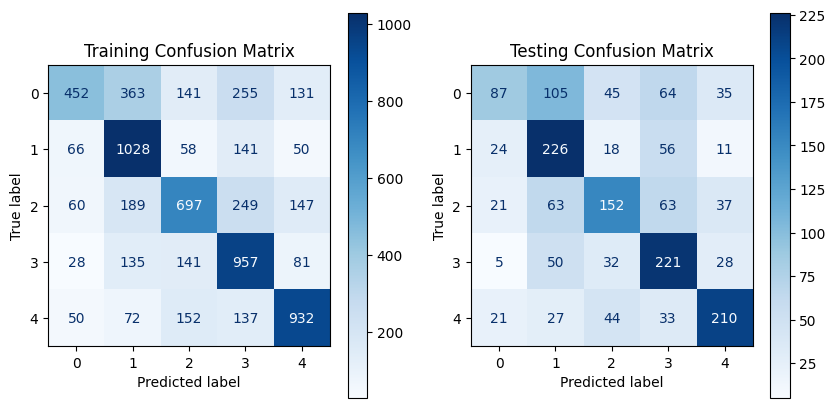

In [37]:
# Compute confusion matrices
train_cm = confusion_matrix(np.argmax(y_train, axis=1), y_train_pred_classes)
test_cm = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred_classes)

# Display confusion matrix for training data
plt.figure(figsize=(10, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=np.unique(np.argmax(y_train, axis=1)))
disp.plot(cmap=plt.cm.Blues, ax=plt.subplot(121))
plt.title('Training Confusion Matrix')

# Display confusion matrix for test data
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=np.unique(np.argmax(y_test, axis=1)))
disp.plot(cmap=plt.cm.Blues, ax=plt.subplot(122))
plt.title('Testing Confusion Matrix')

plt.show()

In [38]:
# Calculate test accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# Calculate train accuracy
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=1)

# Print the results
print(f"Test accuracy: {test_accuracy}")
print(f"Train accuracy: {train_accuracy}")

# Classification report
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_test_pred_classes))


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5407 - loss: 1.1870
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6024 - loss: 1.0832
Test accuracy: 0.533968985080719
Train accuracy: 0.6057807207107544
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.26      0.35       336
           1       0.48      0.67      0.56       335
           2       0.52      0.45      0.48       336
           3       0.51      0.66      0.57       336
           4       0.65      0.63      0.64       335

    accuracy                           0.53      1678
   macro avg       0.54      0.53      0.52      1678
weighted avg       0.54      0.53      0.52      1678



In [39]:
labels = photos_df['label'].values.reshape(-1, 1)
# Initialize and fit the encoder
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(labels)

C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(sparse=False, sparse_output=False)

In [40]:

joblib.dump(onehot_encoder, 'onehot_encoder.pkl') 


['onehot_encoder.pkl']

In [41]:
y_predict = model.predict(X_test)
y_predict_classes = tf.argmax(y_predict, axis=1).numpy()  

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [42]:
y_pred = np.argmax(y_predict, axis=1)

In [43]:
model.save('model.keras')

In [44]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import tensorflow as tf
import joblib

In [45]:
def predict_image_with_label_and_probability(model, image_path, onehot_encoder):
    img = load_img(image_path, target_size=(128, 128)) 
    
    img_array = img_to_array(img) / 255.0  
    img_array = np.expand_dims(img_array, axis=0)
    # Make prediction using the model
    predictions = model.predict(img_array)
    
    predicted_class_index = np.argmax(predictions, axis=1)
    
    # Convert the numerical label back to the original label using the one-hot encoder
    predicted_label = onehot_encoder.inverse_transform(predictions)

    # Get the probability of the predicted class
    predicted_probability = np.max(predictions)  

    return predicted_label[0][0], predicted_probability  

In [46]:



# Example:
image_path = r"C:\Users\pc\Downloads\yelp_photos\photos\__RMLkfCq_spMU1Q5TDHnA.jpg"  
onehot_encoder = joblib.load('onehot_encoder.pkl') 
predicted_label, predicted_probability = predict_image_with_label_and_probability(model, image_path, onehot_encoder)

print(f"Predicted Label: {predicted_label}")
print(f"Probability of Predicted Label: {predicted_probability:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Label: drink
Probability of Predicted Label: 0.3062
